In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')
h     = cosmo.cosmo.params.h


#Config params. Can change as you need. I store these as a dict and then unpack.
bpar_S19 = dict(theta_ej = 4, theta_co = 0.1, M_c = 1e14/h, mu_beta = 0.4,
                eta = 0.3, eta_delta = 0.3, tau = -1.5, tau_delta = 0, #Must use tau here since we go down to low mass
                A = 0.09/2, M1 = 2.5e11/h, epsilon_h = 0.015, 
                a = 0.3, n = 2, epsilon = 4, p = 0.3, q = 0.707, gamma = 2, delta = 7)

bpar_A20 = dict(alpha_g = 2, epsilon_h = 0.015, M1_0 = 2.2e11/h, 
                alpha_fsat = 1, M1_fsat = 1, delta_fsat = 1, gamma_fsat = 1, eps_fsat = 1,
                M_c = 1.2e14/h, eta = 0.6, mu = 0.31, beta = 0.6, epsilon_hydro = np.sqrt(5),
                M_inn = 3.3e13/h, M_r = 1e16, beta_r = 2, theta_inn = 0.1, theta_out = 3,
                theta_rg = 0.3, sigma_rg = 0.1, a = 0.3, n = 2, p = 0.3, q = 0.707,
                A_nt = 0.495, alpha_nt = 0.1,
                mean_molecular_weight = 0.59,
                )

bpar_M20 = bfg.Profiles.Mead20.Params_TAGN_7p8_MPr

#Separately deal with the HOD parameters.
bpar_HOD = dict(Mstar_th=10**11.4,
                M1_fshmr=10**12.55, log10M1_a_fshmr=0.38,
                Mstar0_fshmr=10**10.72, log10Mstar0_a_fshmr=0.55,
                beta_fshmr=0.4, beta_a_fshmr=0.2, 
                delta_shmr=0.37, delta_a_shmr=0.21, 
                gamma_fshmr=1.79, gamma_a_fshmr=-0.72,
                siglogMstar_Ncen=0.7, Bsat_Nsat=9.01, betasat_Nsat=0.3, 
                Bcut_Nsat=1.69, betacut_Nsat=0.6, alphasat_Nsat=1.1
               )

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

# Baryon fraction scaling relations

You can use the ``HODTransformer`` objects to convert any profile into one that follows the stellar fractions defined by the HOD model. This can be applied to any of the profiles within BaryonForge. In the example to follow, notice how the fstar relations are become identical once we've applied the Transformer. There is a minor difference in the Schneider case, because the fractions are defined at M(r < infty) whereas the other models use M(r < R200c). The overall shapes are similar. In the case of Arico and Mead, the relations are identical.

**Note:** While BaryonForge has a lot of nice Profile-level arithmetic you can apply (e.g. do Total = Gas + Stars + DM, at the profile class level) it is best to apply the transformer to each individual profile and not to the combined addition of profiles.

/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/HOD.py:53: RuntimeWarning: overflow encountered in power
  return np.power(10, log10_inv_fSHMR)


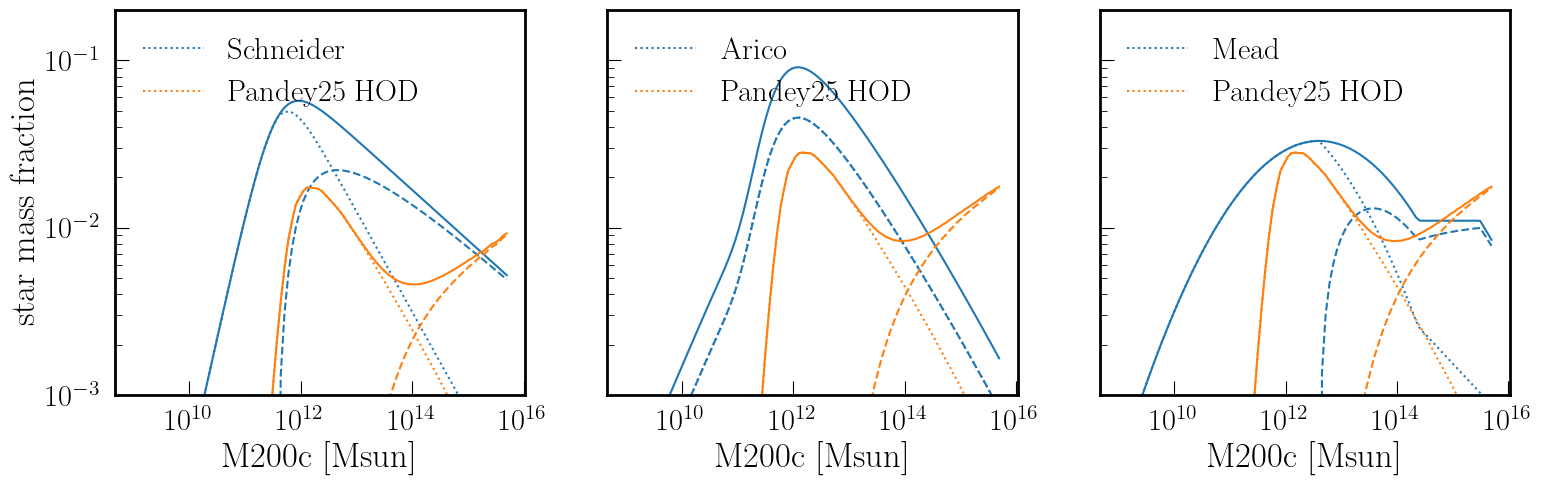

In [3]:
fig, ax = plt.subplots(1, 3, figsize = (18,5), sharey = True, sharex = True)
plt.xscale('log')

M200c = np.geomspace(1e9, 5e15, 100)

#All of the Schneider Profiles carry methods for computing fractions, so let's use DM one here
S = bfg.Profiles.Schneider19.DarkMatter(**bpar_S19)
c = ax[0].plot(M200c, S.get_f_star_cen(M200c, 1, cosmo), ls = ':', label = 'Schneider')
ax[0].plot(M200c, S.get_f_star_sat(M200c, 1, cosmo), ls = '--', color = c[0].get_color())
ax[0].plot(M200c, S.get_f_star(M200c, 1, cosmo), ls = '-', color = c[0].get_color())

M = bfg.Profiles.misc.Mdelta_to_Mtot(S)
S = bfg.Profiles.HOD.HODTransformerPandey25(S, **(bpar_S19 | bpar_HOD), halo_m_to_mtot = M)
c = ax[0].plot(M200c, S.get_f_star_cen(M200c, 1, cosmo), ls = ':', label = 'Pandey25 HOD')
ax[0].plot(M200c, S.get_f_star_sat(M200c, 1, cosmo), ls = '--', color = c[0].get_color())
ax[0].plot(M200c, S.get_f_star(M200c, 1, cosmo), ls = '-', color = c[0].get_color())


#Now do the same, but with Arico20
S = bfg.Profiles.Arico20.DarkMatter(**bpar_A20)
c = ax[1].plot(M200c, S.get_f_star_cen(M200c, 1, cosmo), ls = ':', label = 'Arico')
ax[1].plot(M200c, S.get_f_star_sat(M200c, 1, cosmo), ls = '--', color = c[0].get_color())
ax[1].plot(M200c, S.get_f_star(M200c, 1, cosmo), ls = '-', color = c[0].get_color())

M = bfg.Profiles.misc.Mdelta_to_Mtot(S)
S = bfg.Profiles.HOD.HODTransformerPandey25(S, **(bpar_A20 | bpar_HOD), halo_m_to_mtot = M)
c = ax[1].plot(M200c, S.get_f_star_cen(M200c, 1, cosmo), ls = ':', label = 'Pandey25 HOD')
ax[1].plot(M200c, S.get_f_star_sat(M200c, 1, cosmo), ls = '--', color = c[0].get_color())
ax[1].plot(M200c, S.get_f_star(M200c, 1, cosmo), ls = '-', color = c[0].get_color())


#Now do the same, but with Mead20
S = bfg.Profiles.Mead20.DarkMatter(**bpar_M20)
c = ax[2].plot(M200c, S.get_f_star_cen(M200c, 1, cosmo), ls = ':', label = 'Mead')
ax[2].plot(M200c, S.get_f_star_sat(M200c, 1, cosmo), ls = '--', color = c[0].get_color())
ax[2].plot(M200c, S.get_f_star(M200c, 1, cosmo), ls = '-', color = c[0].get_color())

M = bfg.Profiles.misc.Mdelta_to_Mtot(S)
S = bfg.Profiles.HOD.HODTransformerPandey25(S, **(bpar_M20 | bpar_HOD), halo_m_to_mtot = M)
c = ax[2].plot(M200c, S.get_f_star_cen(M200c, 1, cosmo), ls = ':', label = 'Pandey25 HOD')
ax[2].plot(M200c, S.get_f_star_sat(M200c, 1, cosmo), ls = '--', color = c[0].get_color())
ax[2].plot(M200c, S.get_f_star(M200c, 1, cosmo), ls = '-', color = c[0].get_color())

ax[0].set_yscale('log')
ax[0].set_ylim(1e-3, 2e-1)
[a.legend(loc = 'upper left') for a in ax]
ax[0].set_ylabel('star mass fraction', size = 25)
[a.set_xlabel('M200c [Msun]', size = 25) for a in ax]
[a.tick_params(pad = 10) for a in ax]
plt.show()

# Profile comparison

/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/HOD.py:53: RuntimeWarning: overflow encountered in power
  return np.power(10, log10_inv_fSHMR)


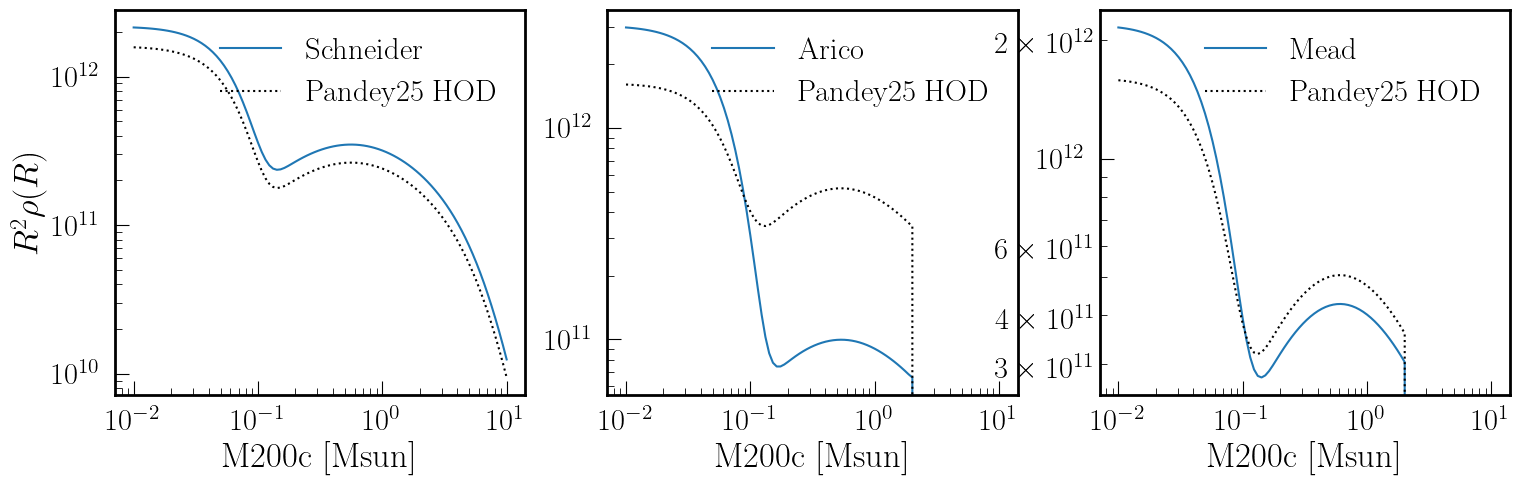

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (18,5), sharey = False, sharex = True)
plt.xscale('log')

M200c = 1e15
R     = np.geomspace(1e-2, 10, 100)

#All of the Schneider Profiles carry methods for computing fractions, so let's use DM one here
CEN = bfg.Profiles.Schneider19.Stars(**bpar_S19)
SAT = bfg.Profiles.Schneider19.SatelliteStars(**bpar_S19)
S   = CEN + SAT
ax[0].plot(R, R**2 * S.real(cosmo, R, M200c, 1), label = 'Schneider')

M = bfg.Profiles.misc.Mdelta_to_Mtot(bfg.Profiles.Schneider19.DarkMatter(**bpar_S19))
S = (bfg.Profiles.HOD.HODTransformerPandey25(CEN, **(bpar_S19 | bpar_HOD), halo_m_to_mtot = M) +
     bfg.Profiles.HOD.HODTransformerPandey25(SAT, **(bpar_S19 | bpar_HOD), halo_m_to_mtot = M))
ax[0].plot(R, R**2 * S.real(cosmo, R, M200c, 1), ls = ':', color = 'k', label = 'Pandey25 HOD')


# #Now do the same, but with Arico20
CEN = bfg.Profiles.Arico20.Stars(**bpar_A20)
SAT = bfg.Profiles.Arico20.SatelliteStars(**bpar_A20)
S   = CEN + SAT
ax[1].plot(R, R**2 * S.real(cosmo, R, M200c, 1), label = 'Arico')

M = bfg.Profiles.misc.Mdelta_to_Mtot(bfg.Profiles.Arico20.DarkMatter(**bpar_A20))
S = (bfg.Profiles.HOD.HODTransformerPandey25(CEN, **(bpar_S19 | bpar_HOD), halo_m_to_mtot = M) +
     bfg.Profiles.HOD.HODTransformerPandey25(SAT, **(bpar_S19 | bpar_HOD), halo_m_to_mtot = M))
ax[1].plot(R, R**2 * S.real(cosmo, R, M200c, 1), ls = ':', color = 'k', label = 'Pandey25 HOD')

# #Now do the same, but with Mead20
CEN = bfg.Profiles.Mead20.CentralStars(**bpar_M20)
SAT = bfg.Profiles.Mead20.SatelliteStars(**bpar_M20)
S   = CEN + SAT
ax[2].plot(R, R**2 * S.real(cosmo, R, M200c, 1), label = 'Mead')

M = bfg.Profiles.misc.Mdelta_to_Mtot(bfg.Profiles.Mead20.DarkMatter(**bpar_M20))
S = (bfg.Profiles.HOD.HODTransformerPandey25(CEN, **(bpar_S19 | bpar_HOD), halo_m_to_mtot = M) +
     bfg.Profiles.HOD.HODTransformerPandey25(SAT, **(bpar_S19 | bpar_HOD), halo_m_to_mtot = M))
ax[2].plot(R, R**2 * S.real(cosmo, R, M200c, 1), ls = ':', color = 'k', label = 'Pandey25 HOD')

[a.set_yscale('log') for a in ax]
[a.legend(loc = 'upper right') for a in ax]
ax[0].set_ylabel(r'$R^2 \rho(R)$', size = 25)
[a.set_xlabel('M200c [Msun]', size = 25) for a in ax]
[a.tick_params(pad = 10) for a in ax]
plt.show()

# Ngal power spectrum

In [5]:
ks = np.geomspace(1e-3, 1e1, 1000)

HOD2pt = ccl.halos.profiles_2pt.Profile2ptHOD(r_corr = 0)

mdef = ccl.halos.massdef.MassDef200c
hmf  = ccl.halos.MassFuncTinker10(mass_def=mdef)
bM   = ccl.halos.HaloBiasTinker10(mass_def=mdef)

fft_precision = dict(padding_lo_fftlog = 1e-8, padding_hi_fftlog = 1e8, n_per_decade = 100)

/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:784: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (1.0000000000000001e-11)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:786: UserWarning: Increase integral upper limit, r_max_int (100000.0) < maximum radius (1000000000.0)
  warnings.warn(f"Increase integral upper limit, r_max_int ({self.r_max_int}) < maximum radius ({np.max(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:850: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (1.0000000000000001e-11)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My

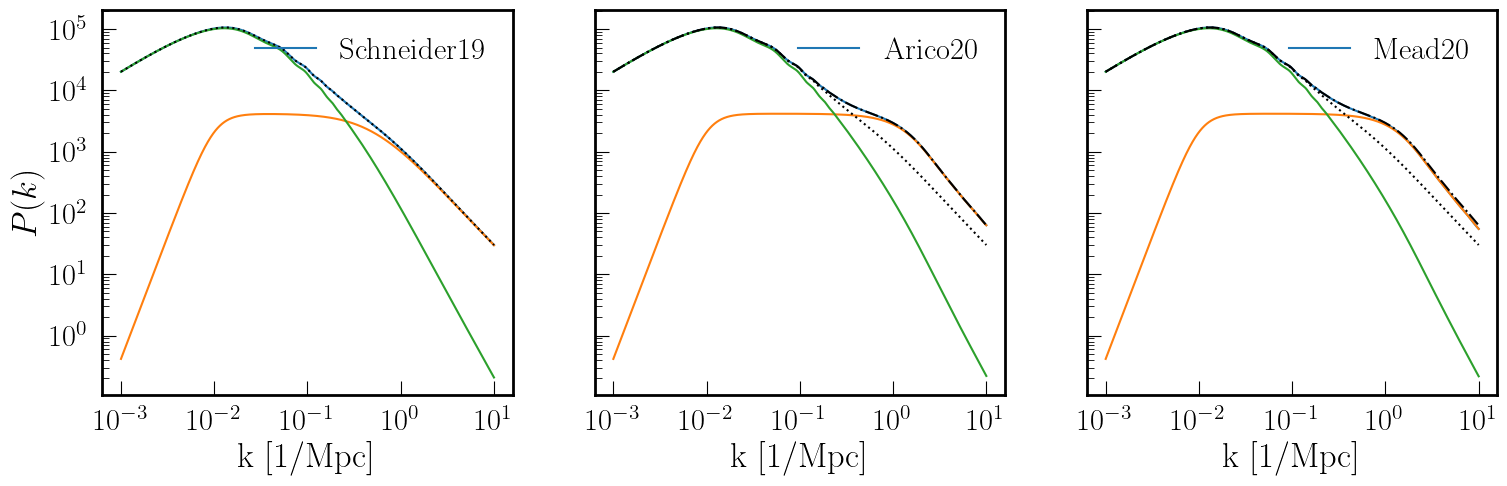

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (18,5), sharey = True, sharex = True)
plt.xscale('log')

a = 1

#All of the Schneider Profiles carry methods for computing fractions, so let's use DM one here
#The FFT precision needs to be the applied to the transformed Sat profile. This is a bit hacky
#but there are many edge-cases and I havent written a general framework for handling this. So
#instead, if you need to update FFT precision you can use the approach below.
Sat    = bfg.Profiles.Schneider19.SatelliteStars(**bpar_S19)
Mtot   = bfg.Profiles.misc.Mdelta_to_Mtot(bfg.Profiles.Schneider19.DarkMatter(**bpar_S19))
Sat    = bfg.Profiles.HOD.HODTransformerPandey25(Sat, Mtot, **(bpar_S19 | bpar_HOD)); Sat.update_precision_fftlog(**fft_precision)
Sat    = bfg.Profiles.HOD.HODGalaxiesPandey25(Sat, Mtot, **bpar_HOD)
HMC    = bfg.utils.FlexibleHMCalculator(mass_function = hmf, halo_bias = bM, halo_m_to_mtot = Mtot, mass_def = mdef,
                                        log10M_min = 8, log10M_max = 16, nM = 30)

pk_gg    = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, suppress_1h = lambda k : 1e-2)
pk_gg_1h = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, suppress_1h = lambda k : 1e-2, get_2h=False)
pk_gg_2h = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, get_1h=False)
ref      = pk_gg * 1
ax[0].plot(ks, pk_gg, label = 'Schneider19')
ax[0].plot(ks, pk_gg_1h)
ax[0].plot(ks, pk_gg_2h)
ax[0].plot(ks, ref, color = 'k', ls = ':')



Sat    = bfg.Profiles.Arico20.SatelliteStars(**bpar_A20)
Mtot   = bfg.Profiles.misc.Mdelta_to_Mtot(bfg.Profiles.Arico20.DarkMatter(**bpar_A20))
Sat    = bfg.Profiles.HOD.HODTransformerPandey25(Sat, Mtot, **(bpar_A20 | bpar_HOD)); Sat.update_precision_fftlog(**fft_precision)
Sat    = bfg.Profiles.HOD.HODGalaxiesPandey25(Sat, Mtot, **bpar_HOD)
HMC    = bfg.utils.FlexibleHMCalculator(mass_function = hmf, halo_bias = bM, halo_m_to_mtot = Mtot, mass_def = mdef,
                                        log10M_min = 8, log10M_max = 16, nM = 30)

pk_gg    = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, suppress_1h = lambda k : 1e-2)
pk_gg_1h = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, suppress_1h = lambda k : 1e-2, get_2h=False)
pk_gg_2h = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, get_1h=False)
ref2     = pk_gg * 1

ax[1].plot(ks, pk_gg, label = 'Arico20')
ax[1].plot(ks, pk_gg_1h)
ax[1].plot(ks, pk_gg_2h)
ax[1].plot(ks, ref,  color = 'k', ls = ':')
ax[1].plot(ks, ref2, color = 'k', ls = '-.')



Sat    = bfg.Profiles.Mead20.SatelliteStars(**bpar_M20)
Mtot   = bfg.Profiles.misc.Mdelta_to_Mtot(bfg.Profiles.Mead20.DarkMatter(**bpar_M20))
Sat    = bfg.Profiles.HOD.HODTransformerPandey25(Sat, Mtot, **(bpar_M20 | bpar_HOD)); Sat.update_precision_fftlog(**fft_precision)
Sat    = bfg.Profiles.HOD.HODGalaxiesPandey25(Sat, Mtot, **bpar_HOD)
HMC    = bfg.utils.FlexibleHMCalculator(mass_function = hmf, halo_bias = bM, halo_m_to_mtot = Mtot, mass_def = mdef,
                                        log10M_min = 8, log10M_max = 16, nM = 30)

pk_gg    = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, suppress_1h = lambda k : 1e-2)
pk_gg_1h = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, suppress_1h = lambda k : 1e-2, get_2h=False)
pk_gg_2h = ccl.halos.halomod_power_spectrum(cosmo, HMC, ks, a, prof=Sat, prof_2pt=HOD2pt, get_1h=False)

ax[2].plot(ks, pk_gg, label = 'Mead20')
ax[2].plot(ks, pk_gg_1h)
ax[2].plot(ks, pk_gg_2h)
ax[2].plot(ks, ref,  color = 'k', ls = ':')
ax[2].plot(ks, ref2, color = 'k', ls = '-.')


[a.set_yscale('log') for a in ax]
[a.legend(loc = 'upper right') for a in ax]
ax[0].set_ylabel(r'$P(k)$', size = 25)
[a.set_xlabel('k [1/Mpc]', size = 25) for a in ax]
[a.tick_params(pad = 10) for a in ax]
[a.set_xticks(np.geomspace(1e-3, 1e1, 5)) for a in ax]
plt.show()